In [28]:
from sklearnex import patch_sklearn
patch_sklearn()

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import TSNE

from sklearn.mixture import GaussianMixture

from utils import get_data, draw_ellipse

# sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [29]:
X, y, metadata, variables = get_data('wine_quality')
X.shape

(6497, 11)

In [30]:
y.value_counts(normalize=True)

quality
6          0.436509
5          0.329075
7          0.166077
4          0.033246
8          0.029706
3          0.004618
9          0.000770
Name: proportion, dtype: float64

In [31]:
# Split data into train and test sets.
# We use Stratifield sampling to ensure that the distribution of the data is maintained across the sample.
# Use stratified kfold cross validation to ensure that the model is not overfitting the data

TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

# Apply PCA and GMM

In [68]:
RANDOM_STATE = 42
PCA_N_COMPONENTS = 8
N_JOBS = -1

scaler = StandardScaler()
dim_redn = PCA(n_components=PCA_N_COMPONENTS, random_state=RANDOM_STATE)
clus = GaussianMixture(random_state=RANDOM_STATE)

clus_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('dim_redn', dim_redn),
    ('model', clus)
])


In [69]:
results = {}
for n_components in range(2, 20):
    print(f"---------- n_components: {n_components} ----------")
    clus_pipeline.set_params(model__n_components=n_components)
    clus_pipeline.fit(X_train)

    # calc the score based on the dim reduced data
    X_dr = clus_pipeline[:-1].transform(X_train)
    
    results[n_components] = {'aic': clus_pipeline.named_steps['model'].aic(X_dr),
                            'bic': clus_pipeline.named_steps['model'].bic(X_dr),
                            'score': clus_pipeline.named_steps['model'].score(X_dr),
                        }

---------- n_components: 2 ----------
---------- n_components: 3 ----------
---------- n_components: 4 ----------
---------- n_components: 5 ----------
---------- n_components: 6 ----------
---------- n_components: 7 ----------
---------- n_components: 8 ----------
---------- n_components: 9 ----------
---------- n_components: 10 ----------
---------- n_components: 11 ----------
---------- n_components: 12 ----------
---------- n_components: 13 ----------
---------- n_components: 14 ----------
---------- n_components: 15 ----------
---------- n_components: 16 ----------
---------- n_components: 17 ----------
---------- n_components: 18 ----------
---------- n_components: 19 ----------


Text(0.5, 1.0, 'AIC and BIC for GMM with PCA(8), Wine Quality')

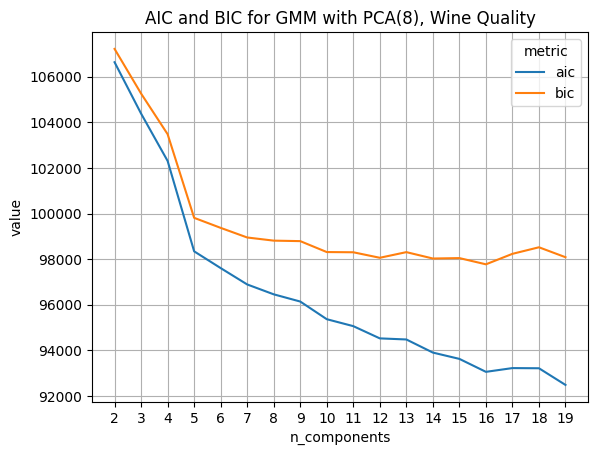

In [70]:
results_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
results_df.columns = ['n_components', 'aic', 'bic', 'score']

plot_df = results_df.melt(id_vars='n_components', var_name='metric', value_name='value').query('metric in ["aic", "bic"]')
ax = sns.lineplot(plot_df, x='n_components', y='value', hue='metric')
ax.set_xticks(results_df['n_components'])
ax.grid()
ax.set_title('AIC and BIC for GMM with PCA(8), Wine Quality')

<Axes: title={'center': 'Score of GMM with PCA(8), Wine Quality'}, xlabel='n_components'>

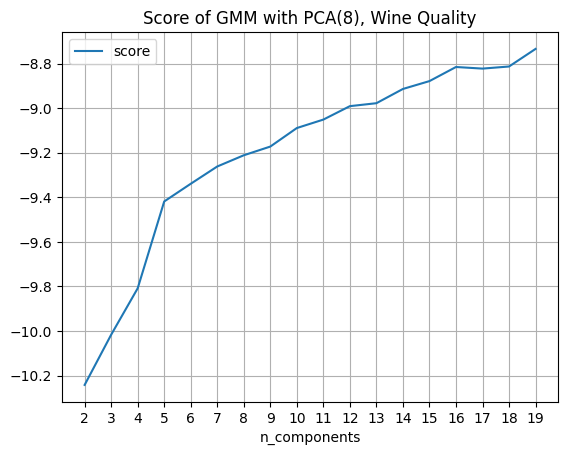

In [71]:
results_df.plot(x='n_components', y='score',title='Score of GMM with PCA(8), Wine Quality', xticks=results_df['n_components'], grid=True)

In [72]:
# Get the PCA transformed data
X_pca = clus_pipeline[:-1].transform(X_train)
X_pca.shape

(5197, 8)

In [76]:
#  Get the Exp Max labels and means
clus_pipeline.set_params(model__n_components=5)

label = clus_pipeline.fit_predict(X_train)
print(label.shape)

means = clus_pipeline.named_steps['model'].means_
covariances = clus_pipeline.named_steps['model'].covariances_
weights = clus_pipeline.named_steps['model'].weights_

w_factor = 0.2 / weights.max()


(5197,)


In [77]:
# Get two components cov for plotting
covariances_2 = covariances[:, 0:2, 0:2]
covariances_2

array([[[ 0.6758547 ,  0.61038814],
        [ 0.61038814,  1.71112756]],

       [[ 0.79535318,  0.53701064],
        [ 0.53701064,  1.20614564]],

       [[ 0.5873971 , -0.01554472],
        [-0.01554472,  1.56337088]],

       [[ 3.86127497, -1.41013943],
        [-1.41013943,  2.72757918]],

       [[ 0.32103719, -0.00917289],
        [-0.00917289,  0.85043777]]])

Text(0.5, 1.0, 'GaussMix(5) clustering with PCA(8), Wine Quality')

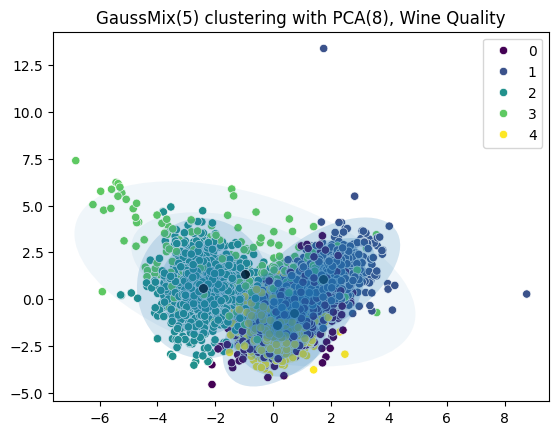

In [78]:
fig, ax = plt.subplots()
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=label, palette='viridis', ax=ax)
sns.scatterplot(x=means[:,0], y=means[:,1], color='black', s=50, marker='o', ax=ax)

for pos, covar, w in zip(means, covariances_2, weights):
        draw_ellipse(pos, covar, alpha=w * w_factor)

ax.set_title("GaussMix(5) clustering with PCA(8), Wine Quality")


Text(0.5, 1.0, 'Original labeling with PCA(8), Wine Quality')

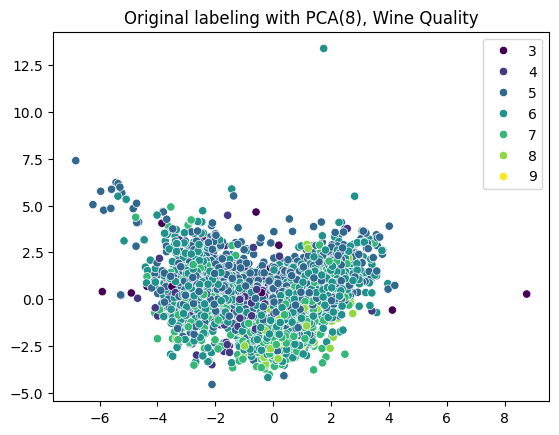

In [16]:
fig, ax = plt.subplots()
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_train.values[:, 0], palette='viridis', ax=ax)
ax.set_title("Original labeling with PCA(8), Wine Quality")

# Apply ICA and GMM

In [79]:
RANDOM_STATE = 42
ICA_N_COMPONENTS = 8

scaler = StandardScaler()
dim_redn = FastICA(n_components=ICA_N_COMPONENTS, random_state=RANDOM_STATE)
clus = GaussianMixture(random_state=RANDOM_STATE)

clus_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('dim_redn', dim_redn),
    ('model', clus)
])


In [80]:
results = {}
for n_components in range(2, 20):
    print(f"---------- n_components: {n_components} ----------")
    clus_pipeline.set_params(model__n_components=n_components)
    clus_pipeline.fit(X_train)

    # calc the core based on the dim reduced data
    X_dr = clus_pipeline[:-1].transform(X_train)
    
    results[n_components] = {'aic': clus_pipeline.named_steps['model'].aic(X_dr),
                            'bic': clus_pipeline.named_steps['model'].bic(X_dr),
                            'score': clus_pipeline.named_steps['model'].score(X_dr),
                        }

---------- n_components: 2 ----------
---------- n_components: 3 ----------
---------- n_components: 4 ----------
---------- n_components: 5 ----------
---------- n_components: 6 ----------
---------- n_components: 7 ----------
---------- n_components: 8 ----------
---------- n_components: 9 ----------
---------- n_components: 10 ----------
---------- n_components: 11 ----------
---------- n_components: 12 ----------
---------- n_components: 13 ----------
---------- n_components: 14 ----------
---------- n_components: 15 ----------
---------- n_components: 16 ----------
---------- n_components: 17 ----------
---------- n_components: 18 ----------
---------- n_components: 19 ----------


Text(0.5, 1.0, 'AIC and BIC for GMM with ICA(8), Wine Quality')

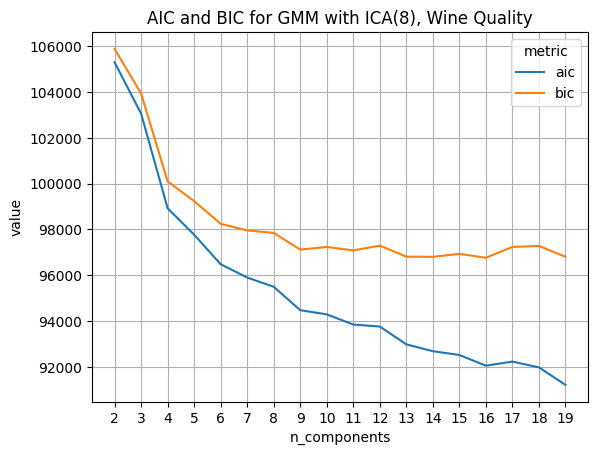

In [81]:
results_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
results_df.columns = ['n_components', 'aic', 'bic', 'score']

plot_df = results_df.melt(id_vars='n_components', var_name='metric', value_name='value').query('metric in ["aic", "bic"]')
ax = sns.lineplot(plot_df, x='n_components', y='value', hue='metric')
ax.set_xticks(results_df['n_components'])
ax.grid()
ax.set_title('AIC and BIC for GMM with ICA(8), Wine Quality')

<Axes: title={'center': 'Score of GMM with PCA(8), Wine Quality'}, xlabel='n_components'>

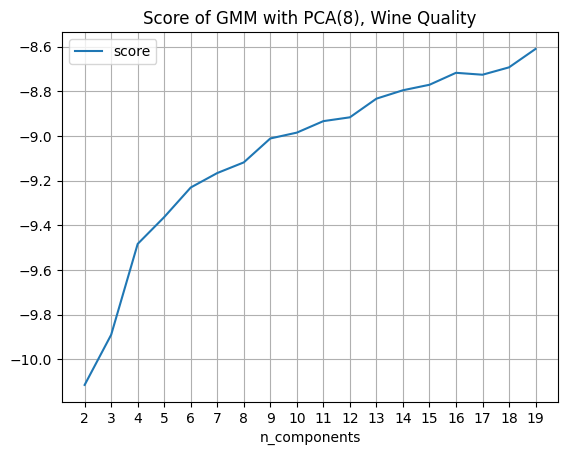

In [82]:
results_df.plot(x='n_components', y='score',title='Score of GMM with PCA(8), Wine Quality', xticks=results_df['n_components'], grid=True)

In [83]:
# Get the ICA transformed data
X_ica = clus_pipeline[:-1].transform(X_train)
X_ica.shape

(5197, 8)

In [87]:
#  Get the K-means labels and centroids
clus_pipeline.set_params(model__n_components=4)

label = clus_pipeline.fit_predict(X_train)
print(label.shape)

means = clus_pipeline.named_steps['model'].means_
covariances = clus_pipeline.named_steps['model'].covariances_
weights = clus_pipeline.named_steps['model'].weights_

w_factor = 0.2 / weights.max()

(5197,)


In [88]:
# Get two components cov for plotting
covariances_2 = covariances[:, 0:2, 0:2]
covariances_2

array([[[ 0.84485901, -0.03326791],
        [-0.03326791,  0.32565796]],

       [[ 0.58739877, -0.06307905],
        [-0.06307905,  0.29526559]],

       [[ 1.00839859, -0.0564541 ],
        [-0.0564541 ,  1.66334148]],

       [[ 3.23649817,  0.2942389 ],
        [ 0.2942389 ,  1.74051418]]])

Text(0.5, 1.0, 'GaussMix(4) clustering with ICA(8), Wine Quality')

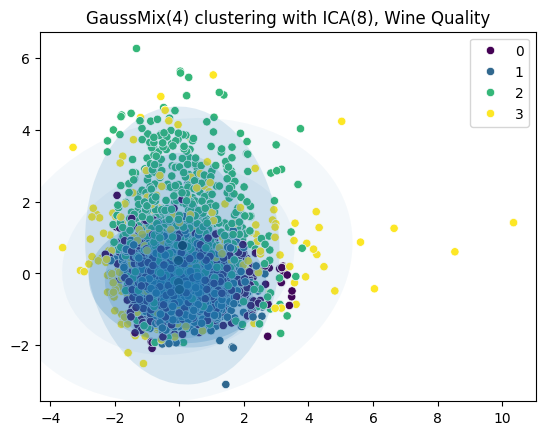

In [89]:
fig, ax = plt.subplots()
sns.scatterplot(x=X_ica[:,0], y=X_ica[:,1], hue=label, palette='viridis', ax=ax)
sns.scatterplot(x=means[:,0], y=means[:,1], color='black', s=50, marker='o', ax=ax)

for pos, covar, w in zip(means, covariances_2, weights):
        draw_ellipse(pos, covar, alpha=w * w_factor)

ax.set_title("GaussMix(4) clustering with ICA(8), Wine Quality")


Text(0.5, 1.0, 'Original labeling with ICA(8), Wine Quality')

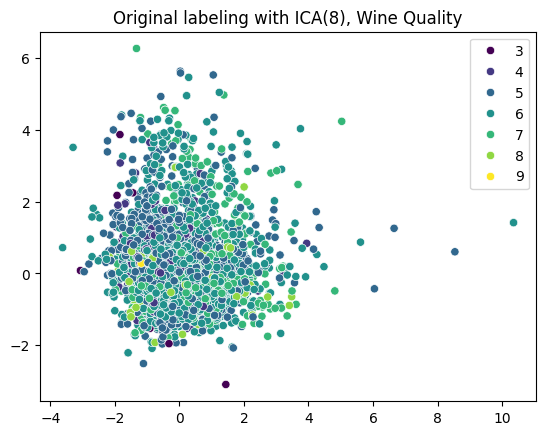

In [90]:
fig, ax = plt.subplots()
sns.scatterplot(x=X_ica[:,0], y=X_ica[:,1], hue=y_train.values[:, 0], palette='viridis', ax=ax)
ax.set_title("Original labeling with ICA(8), Wine Quality")

# Apply Gaussian projection and GMM

In [91]:
RANDOM_STATE = 42
N_COMPONENTS = 8

scaler = StandardScaler()
dim_redn = GaussianRandomProjection(n_components=2, random_state=RANDOM_STATE)
clus = GaussianMixture(random_state=RANDOM_STATE)

clus_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('dim_redn', dim_redn),
    ('model', clus)
])

In [92]:
results = {}
for n_components in range(2, 20):
    print(f"---------- n_components: {n_components} ----------")
    clus_pipeline.set_params(model__n_components=n_components)
    clus_pipeline.fit(X_train)

    # calc the core based on the dim reduced data
    X_dr = clus_pipeline[:-1].transform(X_train)
    
    results[n_components] = {'aic': clus_pipeline.named_steps['model'].aic(X_dr),
                            'bic': clus_pipeline.named_steps['model'].bic(X_dr),
                            'score': clus_pipeline.named_steps['model'].score(X_dr),
                        }


---------- n_components: 2 ----------
---------- n_components: 3 ----------
---------- n_components: 4 ----------
---------- n_components: 5 ----------
---------- n_components: 6 ----------
---------- n_components: 7 ----------
---------- n_components: 8 ----------
---------- n_components: 9 ----------
---------- n_components: 10 ----------
---------- n_components: 11 ----------
---------- n_components: 12 ----------
---------- n_components: 13 ----------
---------- n_components: 14 ----------
---------- n_components: 15 ----------
---------- n_components: 16 ----------
---------- n_components: 17 ----------
---------- n_components: 18 ----------
---------- n_components: 19 ----------


Text(0.5, 1.0, 'AIC and BIC for GMM with Gaus Rand Proj(8), Wine Quality')

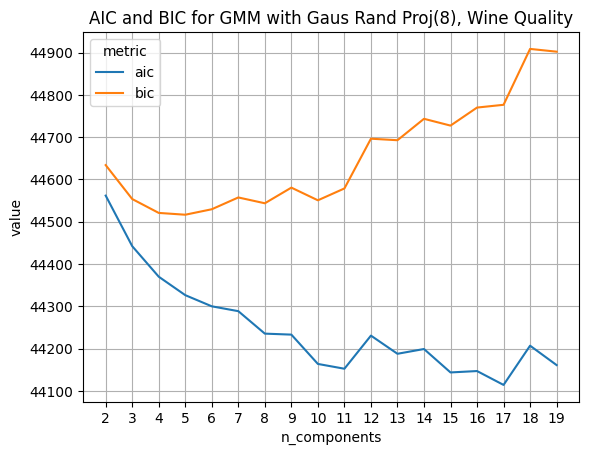

In [93]:
results_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
results_df.columns = ['n_components', 'aic', 'bic', 'score']

plot_df = results_df.melt(id_vars='n_components', var_name='metric', value_name='value').query('metric in ["aic", "bic"]')
ax = sns.lineplot(plot_df, x='n_components', y='value', hue='metric')
ax.set_xticks(results_df['n_components'])
ax.grid()
ax.set_title('AIC and BIC for GMM with Gaus Rand Proj(8), Wine Quality')

<Axes: title={'center': 'Score of GMM with Gaus Rand Proj(8), Wine Quality'}, xlabel='n_components'>

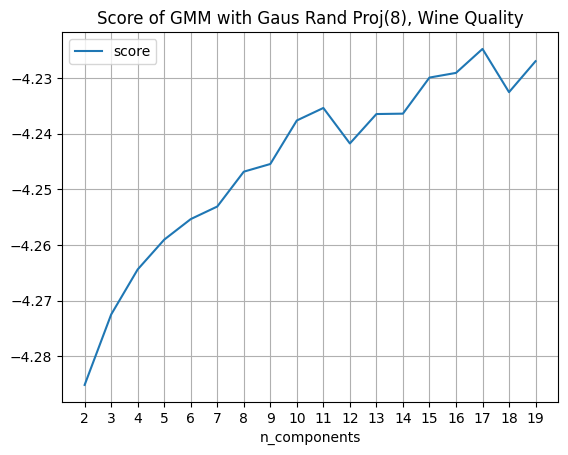

In [94]:
results_df.plot(x='n_components', y='score',title='Score of GMM with Gaus Rand Proj(8), Wine Quality', xticks=results_df['n_components'], grid=True)

In [97]:
# Get the Gauss Rand Proj transformed data
X_rand = clus_pipeline[:-1].fit_transform(X_train)
X_rand.shape

(5197, 2)

In [98]:
#  Get the K-means labels and centroids
clus_pipeline.set_params(model__n_components=4)

label = clus_pipeline.fit_predict(X_train)
print(label.shape)

means = clus_pipeline.named_steps['model'].means_
covariances = clus_pipeline.named_steps['model'].covariances_
weights = clus_pipeline.named_steps['model'].weights_

w_factor = 0.2 / weights.max()

(5197,)


In [99]:
# Get two components cov for plotting
covariances_2 = covariances[:, 0:2, 0:2]
covariances_2

array([[[ 1.86755519, -0.18536709],
        [-0.18536709,  1.66998657]],

       [[ 5.14487976, -4.61834468],
        [-4.61834468, 10.5737583 ]],

       [[ 3.40598166, -0.82840918],
        [-0.82840918,  1.747921  ]],

       [[ 1.62503682, -0.3189485 ],
        [-0.3189485 ,  1.5442592 ]]])

Text(0.5, 1.0, 'GMM(4) clustering with Gaus Rand Proj(8), Dry Beans')

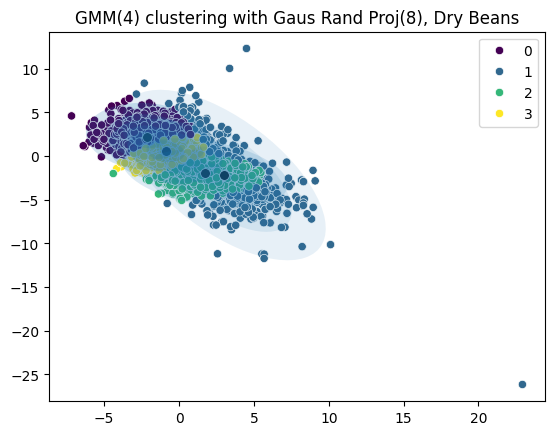

In [100]:
fig, ax = plt.subplots()
sns.scatterplot(x=X_rand[:,0], y=X_rand[:,1], hue=label, palette='viridis', ax=ax)
sns.scatterplot(x=means[:,0], y=means[:,1], color='black', s=50, marker='o', ax=ax)

for pos, covar, w in zip(means, covariances_2, weights):
        draw_ellipse(pos, covar, alpha=w * w_factor)

ax.set_title("GMM(4) clustering with Gaus Rand Proj(8), Dry Beans")

# Apply t-SNE

In [101]:
RANDOM_STATE = 42
T_SNE_N_COMPONENTS = 2

scaler = StandardScaler()
dim_redn = TSNE(n_components=T_SNE_N_COMPONENTS, random_state=RANDOM_STATE)
clus = GaussianMixture(random_state=RANDOM_STATE)

dr_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('dim_redn', dim_redn),
])



In [102]:
X_tsne = dr_pipeline.fit_transform(X_train)

c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\daal4py\sklearn\manifold\_t_sne.py:396: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [103]:
results = {}
for n_components in range(2, 20):
    print(f"---------- n_components: {n_components} ----------")
    model =  GaussianMixture(random_state=RANDOM_STATE, n_components=n_components)
    model.fit(X_tsne)
        
    results[n_components] = {'aic': model.aic(X_tsne),
                            'bic': model.bic(X_tsne),
                            'score': model.score(X_tsne),
                        }

---------- n_components: 2 ----------
---------- n_components: 3 ----------
---------- n_components: 4 ----------
---------- n_components: 5 ----------
---------- n_components: 6 ----------
---------- n_components: 7 ----------
---------- n_components: 8 ----------
---------- n_components: 9 ----------
---------- n_components: 10 ----------
---------- n_components: 11 ----------
---------- n_components: 12 ----------
---------- n_components: 13 ----------
---------- n_components: 14 ----------
---------- n_components: 15 ----------
---------- n_components: 16 ----------
---------- n_components: 17 ----------
---------- n_components: 18 ----------
---------- n_components: 19 ----------


Text(0.5, 1.0, 'AIC and BIC for GMM with TSNE, Wine Quality')

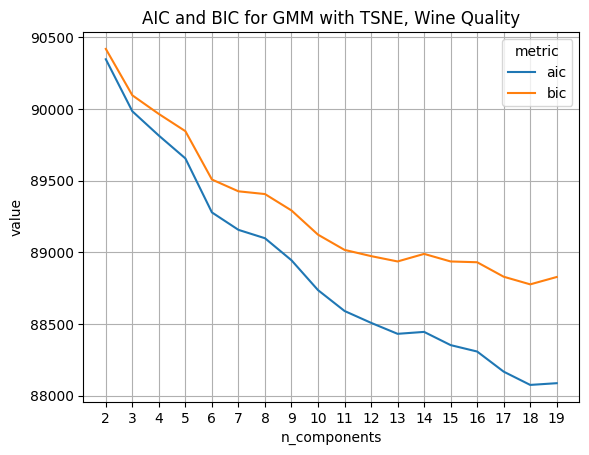

In [104]:
results_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
results_df.columns = ['n_components', 'aic', 'bic', 'score']

plot_df = results_df.melt(id_vars='n_components', var_name='metric', value_name='value').query('metric in ["aic", "bic"]')
ax = sns.lineplot(plot_df, x='n_components', y='value', hue='metric')
ax.set_xticks(results_df['n_components'])
ax.grid()
ax.set_title('AIC and BIC for GMM with TSNE, Wine Quality')

<Axes: title={'center': 'Score of GMM with TSNE, Wine Quality'}, xlabel='n_components'>

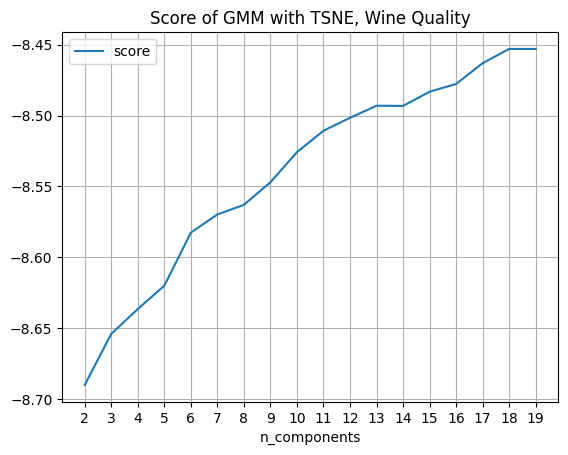

In [105]:
results_df.plot(x='n_components', y='score',title='Score of GMM with TSNE, Wine Quality', xticks=results_df['n_components'], grid=True)

In [106]:
#  Get the K-means labels and centroids
model =  GaussianMixture(random_state=RANDOM_STATE, n_components=6)
label = model.fit_predict(X_tsne)

print(label.shape)

means = model.means_
covariances = model.covariances_
weights = model.weights_

w_factor = 0.2 / weights.max()

(5197,)


Text(0.5, 1.0, 'GaussMix(6) clustering with TSNE(2), Wine Quality')

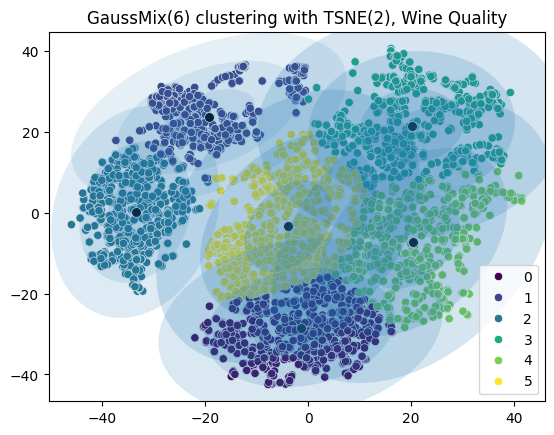

In [108]:
fig, ax = plt.subplots()
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=label, palette='viridis', ax=ax)
sns.scatterplot(x=means[:,0], y=means[:,1], color='black', s=50, marker='o', ax=ax)

for pos, covar, w in zip(means, covariances, weights):
        draw_ellipse(pos, covar, alpha=w * w_factor)

ax.set_title("GaussMix(6) clustering with TSNE(2), Wine Quality")


Text(0.5, 1.0, 'Original labeling with TSNE(2), Wine Quality')

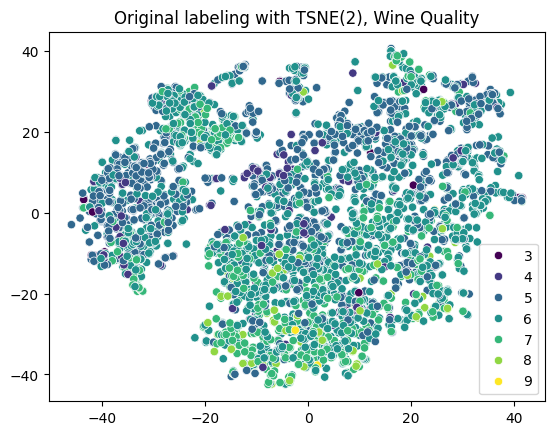

In [43]:
fig, ax = plt.subplots()
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y_train.values[:, 0], palette='viridis', ax=ax)
ax.set_title("Original labeling with TSNE(2), Wine Quality")